In [19]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import signal
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# MNE Libraries
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs

In [20]:
# Define the plot output path
plot_output_path = Path('plot_outputs')

# Create directory if it doesn't exist
plot_output_path.mkdir(exist_ok=True)
print(f"Directory '{plot_output_path}' is ready.")

Directory 'plot_outputs' is ready.


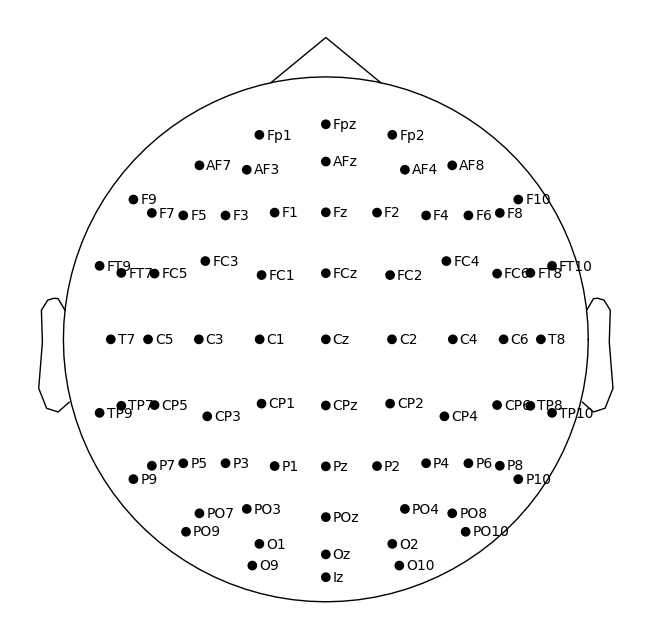

In [21]:
# Set montage
standard_1020_montage = mne.channels.make_standard_montage('easycap-M1')
standard_1020_montage.plot()
plt.show()

# Load Subject Information

In [22]:
# Subject Information
subject_info = pd.read_csv('data/subject_info.csv')

In [23]:
# Define the data directory
data_dir = Path('data')

# Initialize lists to store data
all_seizures = []
all_patients = []

# Load all JSON files from subdirectories
json_files = sorted(list(data_dir.glob('**/*.json')))  # ** searches subdirectories, sorted for consistent order
print(f"Found {len(json_files)} JSON files")
print("Files found:")
for f in json_files:
    print(f"  - {f}")
print("\nLoading data...")

for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Extract patient-level information
        patient_info = {
            'patient_id': data['patient_id'],
            'sampling_rate_hz': data['sampling_rate_hz'],
            'num_channels': len(data['channels']),
            'json_file_path': str(json_file)  # Store the file path for reference
        }
        
        # Check if there's a top-level file_name (like PN01)
        if 'file_name' in data:
            patient_info['file_name'] = data['file_name']
            patient_info['registration_start_time'] = data.get('registration_start_time')
            patient_info['registration_end_time'] = data.get('registration_end_time')
        
        # Store patient info
        all_patients.append(patient_info)
        
        # Process each seizure
        for seizure in data['seizures']:
            seizure_record = {
                'patient_id': data['patient_id'],
                'sampling_rate_hz': data['sampling_rate_hz'],
                'seizure_number': seizure['seizure_number']
            }
            
            # Add all seizure fields dynamically to handle variations
            for key, value in seizure.items():
                seizure_record[key] = value
            
            # If file info is at patient level, add it to seizure record
            if 'file_name' in patient_info and 'file_name' not in seizure:
                seizure_record['file_name'] = patient_info['file_name']
                if 'registration_start_time' in patient_info:
                    seizure_record['registration_start_time'] = patient_info['registration_start_time']
                    seizure_record['registration_end_time'] = patient_info['registration_end_time']
            
            all_seizures.append(seizure_record)
            
    except Exception as e:
        print(f"Error loading {json_file}: {e}")
        continue

print("\nData loading complete!")

# Create DataFrames
seizures_df = pd.DataFrame(all_seizures)
patients_df = pd.DataFrame(all_patients)

Found 14 JSON files
Files found:
  - data\PN00\Seizures-list-PN00.json
  - data\PN01\Seizures-list-PN01.json
  - data\PN03\Seizures-list-PN03.json
  - data\PN05\Seizures-list-PN05.json
  - data\PN06\Seizures-list-PN06.json
  - data\PN07\Seizures-list-PN07.json
  - data\PN09\Seizures-list-PN09.json
  - data\PN10\Seizures-list-PN10.json
  - data\PN11\Seizures-list-PN11.json
  - data\PN12\Seizures-list-PN12.json
  - data\PN13\Seizures-list-PN13.json
  - data\PN14\Seizures-list-PN14.json
  - data\PN16\Seizures-list-PN16.json
  - data\PN17\Seizures-list-PN17.json

Loading data...

Data loading complete!


# Data Loading and Raw EDF Plotting


Processing subject PN00...
Found 5 EDF file(s)
  Processing PN00-1.edf...
    Successfully loaded 35 channels
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)

    Saved raw plot to plot_outputs\PN00_raw_1_edf_plot.png
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting amplitude spectral density (dB=True).
    Saved PSD plot to plot_outputs\PN00raw1_psd_plot.png
    Saved averaged PSD plot to plot_outputs\PN00_raw_1_psd_averaged.png
    Saved regional PSD plot to

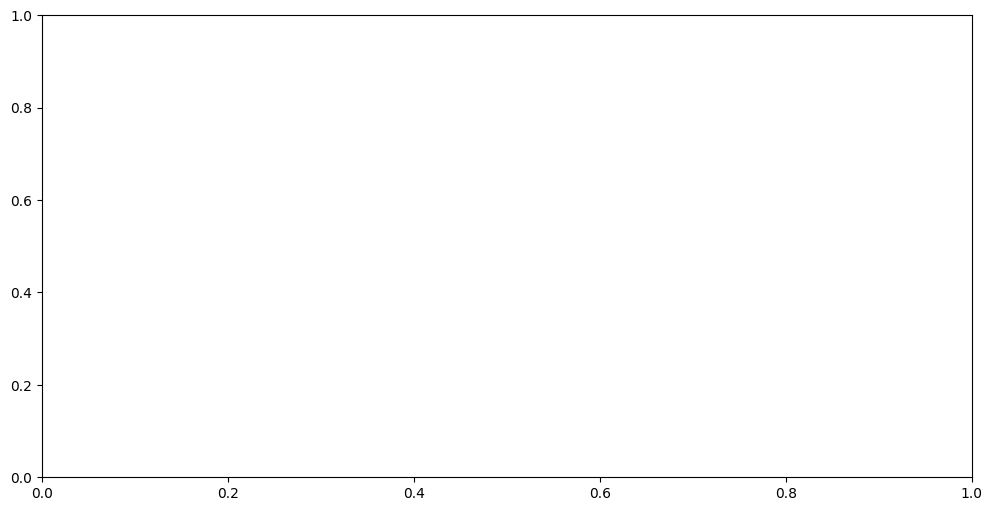

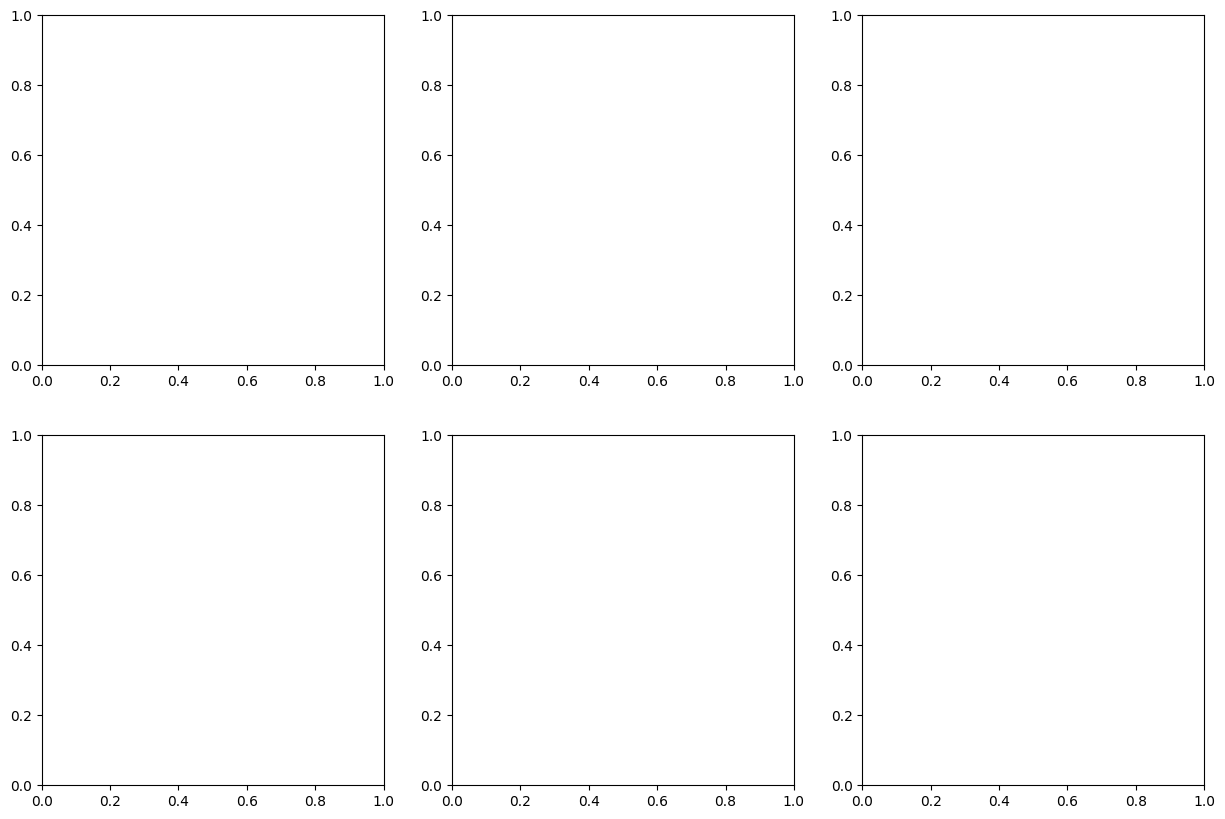

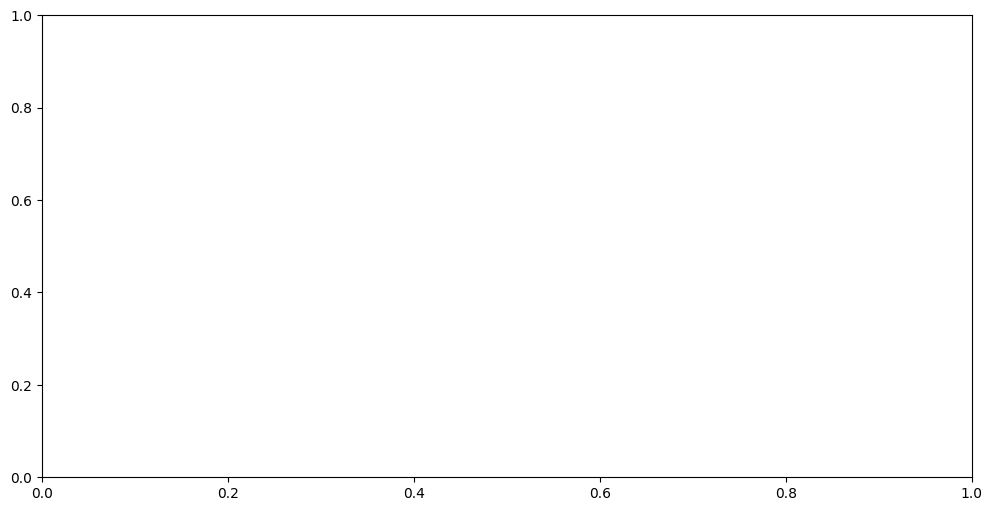

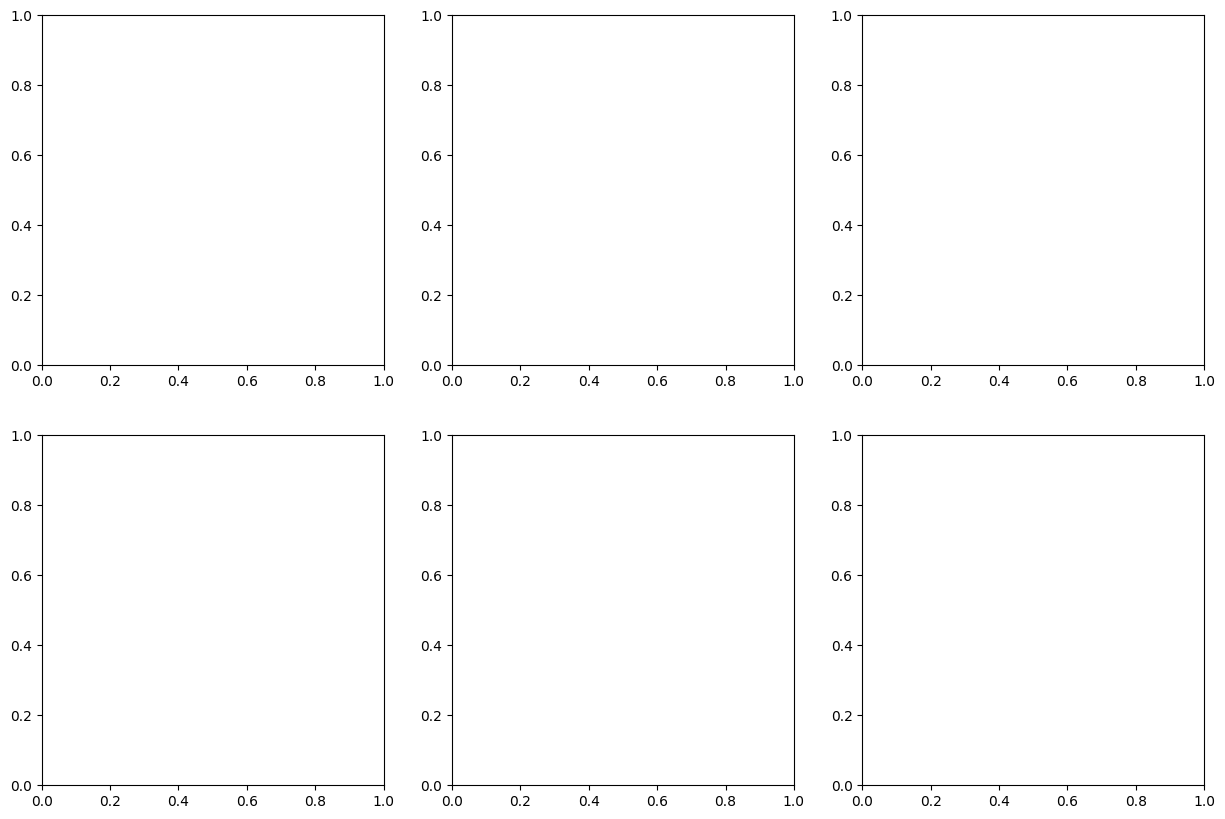

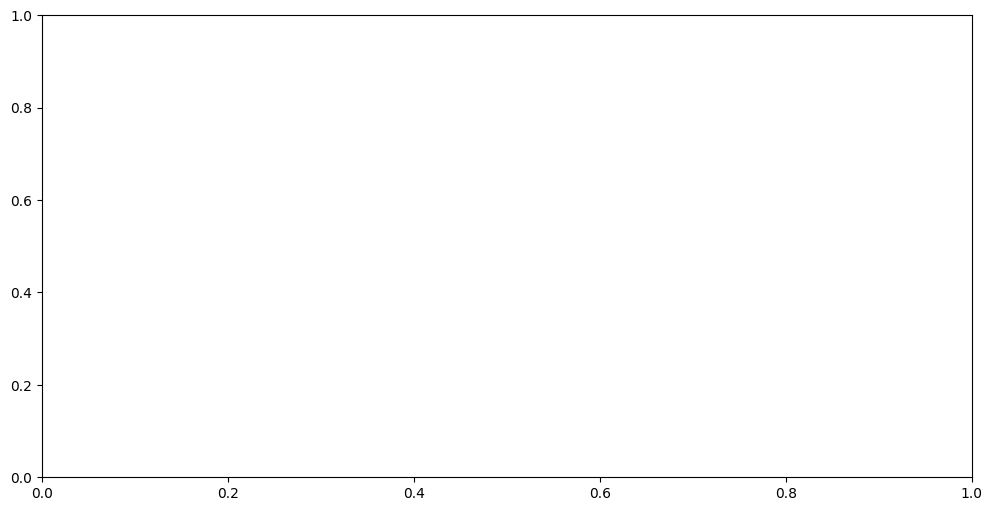

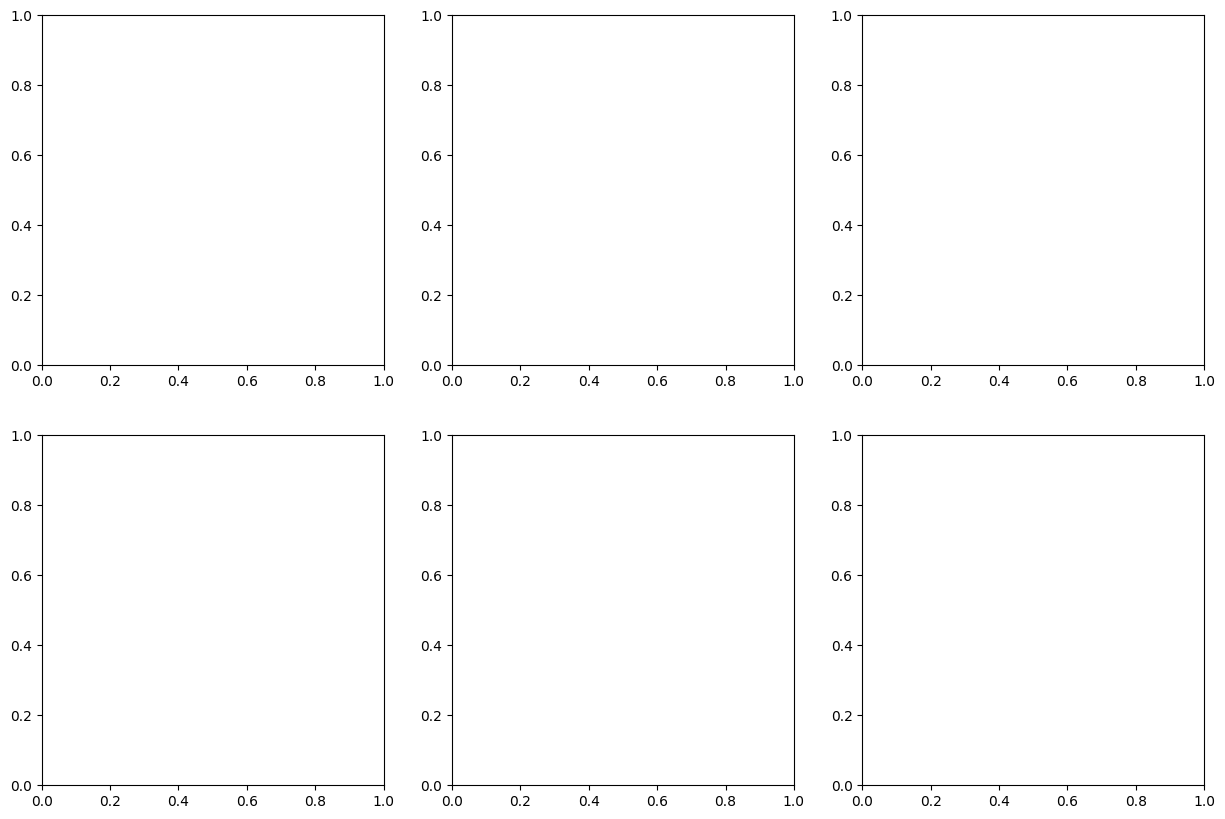

In [39]:
def process_all_edf_files(data_dir='data', output_dir='plot_outputs'):
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Process subjects PN00 through PN17
    for subject_num in range(18):  # 0 to 17
        subject = f'PN{subject_num:02d}'  # Format as PN00, PN01, etc.
        subject_dir = Path(data_dir) / subject
        
        # Check if subject directory exists
        if not subject_dir.exists():
            print(f"Directory {subject_dir} not found, skipping...")
            continue
        
        # Find all .edf files in the subject directory
        edf_files = list(subject_dir.glob('*.edf'))
        
        if not edf_files:
            print(f"No EDF files found in {subject_dir}, skipping...")
            continue
        
        print(f"\nProcessing subject {subject}...")
        print(f"Found {len(edf_files)} EDF file(s)")
        
        # Process each EDF file
        for edf_file in edf_files:
            try:
                # Extract file number from filename (e.g., PN00-1.edf -> 1)
                file_stem = edf_file.stem  # Gets filename without extension
                file_num = file_stem.split('-')[-1] if '-' in file_stem else '1'
                
                print(f"  Processing {edf_file.name}...")
                
                # Load EDF file
                raw = mne.io.read_raw_edf(str(edf_file), preload=True, verbose=False)
                
                # Get available channels
                available_channels = raw.ch_names
                
                # Set channel types
                raw.set_channel_types({'2':'ecg', '1':'ecg'})
                
                # Rename channels (commented out as in your version)
                #raw.rename_channels({
                #    'EEG Fp1':'Fp1', 'EEG F3':'F3', 'EEG C3':'C3', 'EEG P3':'P3', 'EEG O1':'O1', 
                #    'EEG F7':'F7', 'EEG T3':'C1', 'EEG T5':'T7', 'EEG Fc1':'FC1', 'EEG Fc5':'FC5', 
                #    'EEG Cp1':'CP1', 'EEG Cp5':'CP5', 'EEG F9':'F9', 'EEG Fz':'Fz', 'EEG Cz':'Cz', 
                #    'EEG Pz':'Pz', 'EEG Fp2':'Fp2', 'EEG F4':'F4', 'EEG C4':'C4', 'EEG P4':'P4', 
                #    'EEG O2':'O2', 'EEG F8':'F8', 'EEG T4':'C2', 'EEG T6':'T8', 'EEG Fc2':'FC2', 
                #    'EEG Fc6':'FC6', 'EEG Cp2':'CP2', 'EEG Cp6':'CP6', 'EEG F10':'F10', 
                #    'EKG EKG':'AF7', 'SPO2':'Iz', 'HR':'AF8', 'MK':'Fpz'
                #})
                
                print(f"    Successfully loaded {len(available_channels)} channels")
                
                # Apply bandpass filter between 0.5 and 30 Hz
                raw.filter(0.5, 30, fir_design='firwin')
                
                # Plot the raw time series data
                fig = raw.plot(show=False)  # Set show=False to prevent display
                output_filename = output_path / f'{subject}_raw_{file_num}_edf_plot.png'
                fig.savefig(output_filename)
                plt.close(fig)
                print(f"    Saved raw plot to {output_filename}")
                
                # Plot Power Spectral Density (PSD)
                try:
                    fig_psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30).plot(
                        average=False,  # Show individual channels
                        amplitude=True,  # Show in dB
                        spatial_colors=True,  # Color by sensor location
                        show=False
                    )
                    psd_filename = output_path / f'{subject}raw{file_num}_psd_plot.png'
                    fig_psd.savefig(psd_filename)
                    plt.close(fig_psd)
                    print(f"    Saved PSD plot to {psd_filename}")
                except Exception as e:
                    print(f"    Warning: Could not create PSD plot: {str(e)}")
                
    
                try:
                    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
                    # Compute PSD
                    psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30, verbose=False)
                    
                    # Get data and average across channels
                    psds, freqs = psd.get_data(return_freqs=True)
                    psd_mean = np.mean(psds, axis=0)
                    psd_std = np.std(psds, axis=0)
                    
                    # Plot mean with std as shaded area
                    ax.plot(freqs, 10 * np.log10(psd_mean), 'b-', linewidth=2, label='Mean PSD')
                    ax.fill_between(freqs, 
                                10 * np.log10(psd_mean - psd_std), 
                                10 * np.log10(psd_mean + psd_std), 
                                alpha=0.3, label='±1 SD')
                    
                    # Add frequency band annotations
                    ax.axvspan(8, 12, alpha=0.2, color='green', label='Alpha (8-12 Hz)')
                    ax.axvspan(13, 30, alpha=0.2, color='orange', label='Beta (13-30 Hz)')
                    ax.axvspan(4, 7, alpha=0.2, color='blue', label='Theta (4-7 Hz)')
                    
                    ax.set_xlabel('Frequency (Hz)')
                    ax.set_ylabel('Power Spectral Density (dB)')
                    ax.set_title(f'{subject} - Average PSD Across All Channels')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_averaged.png'
                    plt.savefig(psd_filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"    Saved averaged PSD plot to {psd_filename}")
                except Exception as e:
                    print(f"    Warning: Could not create PSD plot: {str(e)}")
                    
                try:
                    # Define channel groups (adjust based on your montage)
                    channel_groups = {
                        'Frontal': ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG Fz'],
                        'Central': ['EEG C3', 'EEG C4', 'EEG Cz'],
                        'Parietal': ['EEG P3', 'EEG P4', 'EEG Pz'],
                        'Occipital': ['EEG O1', 'EEG O2'],
                        'Temporal': ['EEG T3', 'EEG T4', 'EEG T5', 'EEG T6']
                    }
                    
                    # Get available channels
                    available_channels = raw.ch_names
                    
                    # Filter groups to only include available channels
                    filtered_groups = {}
                    for group, channels in channel_groups.items():
                        available_in_group = [ch for ch in channels if ch in available_channels]
                        if available_in_group:
                            filtered_groups[group] = available_in_group
                    
                    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                    axes = axes.flatten()
                    
                    psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30, verbose=False)
                    psds, freqs = psd.get_data(return_freqs=True)
                    
                    colors = ['blue', 'red', 'green', 'orange', 'purple']
                    
                    for idx, (group_name, channels) in enumerate(filtered_groups.items()):
                        if idx >= len(axes):
                            break
                            
                        ax = axes[idx]
                        
                        # Get indices for this group
                        ch_indices = [raw.ch_names.index(ch) for ch in channels if ch in raw.ch_names]
                        
                        if ch_indices:
                            # Average PSD for this group
                            group_psd = np.mean(psds[ch_indices, :], axis=0)
                            group_std = np.std(psds[ch_indices, :], axis=0)
                            
                            ax.plot(freqs, 10 * np.log10(group_psd), 
                                color=colors[idx % len(colors)], linewidth=2)
                            ax.fill_between(freqs, 
                                        10 * np.log10(group_psd - group_std), 
                                        10 * np.log10(group_psd + group_std), 
                                        alpha=0.3, color=colors[idx % len(colors)])
                            
                            ax.set_title(f'{group_name} ({len(channels)} channels)')
                            ax.set_xlabel('Frequency (Hz)')
                            ax.set_ylabel('PSD (dB)')
                            ax.grid(True, alpha=0.3)
                    
                    # Remove empty subplots
                    for idx in range(len(filtered_groups), len(axes)):
                        fig.delaxes(axes[idx])
                    
                    plt.suptitle(f'{subject} - PSD by Brain Regions')
                    plt.tight_layout()
                    
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_by_regions.png'
                    plt.savefig(psd_filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"    Saved regional PSD plot to {psd_filename}")
                    
                except Exception as e:
                    print(f"    Warning: Could not create regional PSD plot: {str(e)}")
                
                
            except Exception as e:
                print(f"    Error processing {edf_file.name}: {str(e)}")
                continue
    
    print(f"\nProcessing complete! All plots saved to {output_dir}/")

# Run the function
process_all_edf_files()